# 【最終課題】写真に写る動物が犬か猫かを分類しよう

## 概要

こちらで用意した犬と猫の画像400枚（それぞれ200枚ずつ）をデータセットとしてプログラムに取り込み、深層学習を行なってください。分類器の精度は合否の基準としませんが、正答率がほぼ0％になる場合はプログラムのどこかが間違っているため不合格の判定になる点、注意してください。

画像のセットを *dog_cat_photos* フォルダに用意しています。これは [Flickr](https://www.flickr.com/) のサイトから入手した著作権フリーの犬と猫の写真（すべて画像サイズは75×75）です。

*dog_cat_photos* フォルダには *train* と *test* というフォルダがあり、さらにそのなかにある *dog* および *cat* フォルダ内には、犬と猫それぞれの写真が入っています。*train* の写真は150枚ずつ、また *test* の写真は50枚ずつ用意しています。

## 仕様

最終課題用のノートブックのなかに、犬と猫の画像を学習したモデルを作成して、分類を行なうプログラムを作成してください。

- 本レッスン内容で学習した流れに沿って、深層学習プログラムを作成してください  
- データの前処理や水増しの処理を入れてください  
- `MobileNetV2` のモデルを利用してください（画像サイズは `MobileNetV2` が対応する大きさへのリサイズが必要です）  
- 必ず最後に `evaluate()` を実行して、正答率がわかるようにしてください。  

## 合格条件

以下の条件を満たしていれば合格となります。

- 全体的に見て、コードに問題がないこと  
- 分類の正答率が0％に近いほどの悪い値でないこと  


## 回答

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

In [55]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "dog_cat_photos/train",
  image_size=(224, 224),
  label_mode='binary',
  batch_size=32,
  shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "dog_cat_photos/test",
  image_size=(224, 224),
  label_mode='binary',
  batch_size=32,
  shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


#### データを確認する

In [56]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

(array([[[[ 58.       ,  33.       ,  26.       ],
          [ 57.96875  ,  32.993305 ,  25.98884  ],
          [ 53.28125  ,  31.98884  ,  24.314732 ],
          ...,
          [188.6741   , 168.6741   , 144.6741   ],
          [188.00446  , 168.00446  , 144.00446  ],
          [188.       , 168.       , 144.       ]],
 
         [[ 58.142857 ,  33.13393  ,  26.136162 ],
          [ 58.111664 ,  33.127285 ,  26.125055 ],
          [ 53.432384 ,  32.13029  ,  24.45917  ],
          ...,
          [188.68376  , 168.68301  , 144.68526  ],
          [188.01561  , 168.0156   , 144.01561  ],
          [188.01115  , 168.01115  , 144.01115  ]],
 
         [[ 79.57143  ,  53.223217 ,  46.56027  ],
          [ 79.548454 ,  53.224045 ,  46.557384 ],
          [ 76.10233  ,  53.348106 ,  46.12466  ],
          ...,
          [190.13216  , 170.01855  , 146.35938  ],
          [189.68822  , 169.68747  , 145.68973  ],
          [189.68527  , 169.68527  , 145.68527  ]],
 
         ...,
 
         [[2

In [57]:
# 分類名（cat／dog）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

In [58]:
import matplotlib.pyplot as plt

def show_train_data_summary(train_dataset, class_names) -> None:
  """訓練データの一部を表示する"""
  plt.figure(figsize=(10, 10))

  for images, labels in train_dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

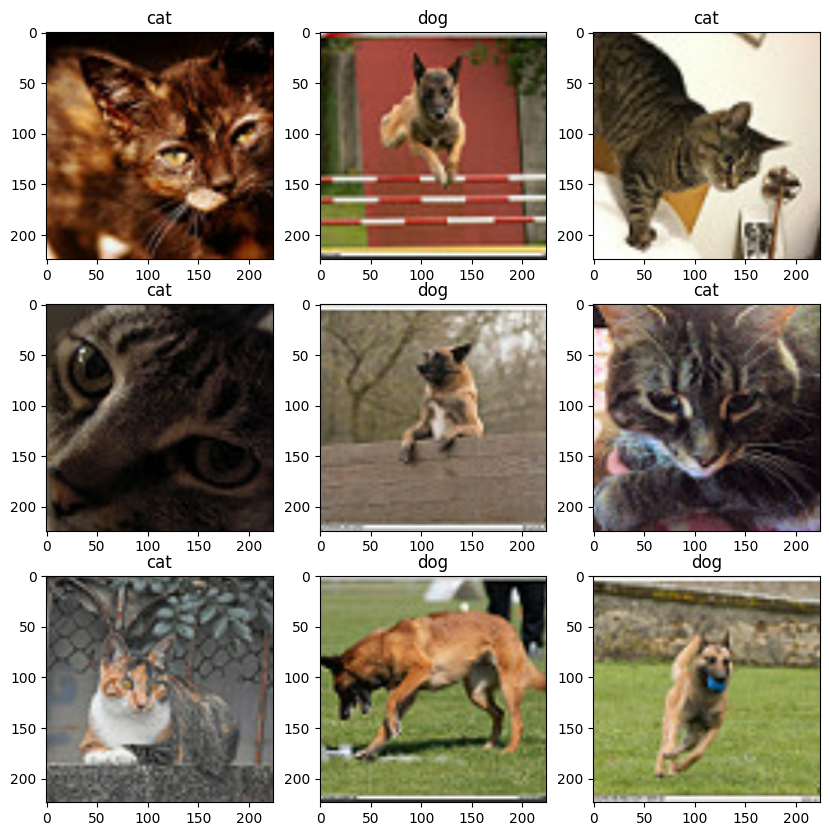

In [59]:
# 訓練データの一部を表示して確認
show_train_data_summary(train_dataset, class_names)

### データの水増しを行なう

In [60]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
  image = tf.image.flip_left_right(image)
  return image, label

def flip_up_down(image, label):      # 上下反転
  image = tf.image.flip_up_down(image)
  return image, label

def rot90(image, label):             # 反時計回りに90度回転
  image = tf.image.rot90(image)
  return image, label

def rot180(image, label):            # 反時計回りに180度回転
  image = tf.image.rot90(image, k=2)
  return image, label

def rot270(image, label):            # 反時計回りに270度回転
  image = tf.image.rot90(image, k=3)
  return image, label

In [61]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [62]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [63]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

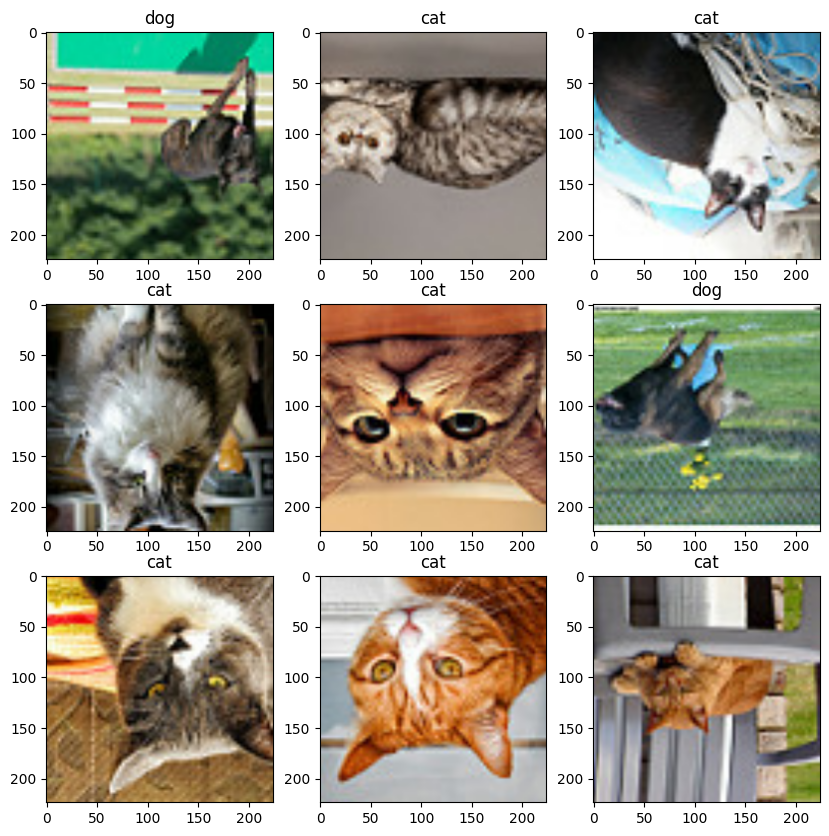

In [64]:
# 訓練データの一部を表示して確認
show_train_data_summary(train_dataset, class_names)

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [65]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
  input_shape=(224, 224, 3),
  input_tensor=l_layer,
  include_top=False,
  weights="imagenet",
  pooling='avg'
)
base_model.trainable = False

#### 出力層を作成する

In [66]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [67]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
  base_model,
  output_layer
])

In [68]:
# modelをcompileする
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [69]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7872 - loss: 0.4466
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9256 - loss: 0.2204
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9489 - loss: 0.1706
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.9583 - loss: 0.1382
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9683 - loss: 0.1155
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9733 - loss: 0.1002
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9800 - loss: 0.0867
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9783 - loss: 0.0788
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9828 - loss: 0.0701
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9872 - loss: 0.0635
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9900 - loss: 0.0576
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155m

In [70]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


In [74]:
# 分類した結果を確認する
pred_data

array([[3.6126225e-05],
       [5.6244753e-04],
       [5.8210117e-05],
       [1.6907601e-03],
       [8.0877566e-04],
       [2.0398344e-04],
       [9.1653457e-04],
       [1.1589233e-03],
       [2.8374683e-05],
       [7.3167129e-04],
       [6.1781153e-05],
       [4.6821646e-03],
       [6.1114551e-03],
       [1.9509729e-03],
       [3.4332184e-05],
       [8.0156951e-06],
       [6.1829887e-05],
       [4.8718086e-04],
       [5.8030542e-03],
       [4.2236890e-03],
       [8.7143295e-03],
       [9.0991274e-02],
       [3.2673823e-03],
       [7.3008944e-04],
       [2.5320932e-01],
       [2.1762252e-03],
       [1.5214796e-03],
       [9.7543589e-04],
       [5.8828299e-03],
       [2.2847181e-04],
       [8.0511440e-04],
       [9.0583485e-01],
       [2.3807523e-04],
       [1.5035893e-03],
       [1.0978301e-02],
       [9.3142653e-01],
       [3.1393580e-03],
       [2.1429088e-03],
       [2.4395386e-02],
       [3.3654342e-04],
       [3.3707387e-04],
       [7.507416

In [75]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9600 - loss: 0.0818


[0.08184963464736938, 0.9599999785423279]